**Kaggle team name**: 🐧1-TheSelfishGene-Na, Rivas, Yoo 
1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`. 
  1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where 🐧 identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

<hr color=red>

# **🏆🧬Genomics**


<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/c/3722genomics/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive) 
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 3722genomics # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 3722genomics
100% 9.65M/9.65M [00:00<00:00, 93.0MB/s]
Using competition: 3722genomics
 teamId  teamName                                 submissionDate       score    
-------  ---------------------------------------  -------------------  -------  
8301149  JB-TheBestDNA-Katsaros,Givre,Natali      2022-03-20 18:53:39  0.98760  
8314244  JF-Genes-Brodsky,Hu                      2022-03-12 01:12:51  0.98710  
8332286  JA-GeneticCoders-Merran,Rumman           2022-03-22 00:28:12  0.98680  
8306609  JD-TheGeneTeam-Khan,Dinh                 2022-03-20 00:48:37  0.98670  
8912603  🐧2-Codebreakers-Cahill,Cui               2022-07-25 00:27:23  0.98610  
8908701  🐧6- Splicers -Acosta,Bollineni           2022-07-24 16:54:37  0.98400  
8909125  🐧4-GeneormusEmbeddings-Sahi,Samman       2022-07-24 12:55:45  0.98360  
8301174  JE-RippedGenes-Li, Packard               2022-03-21 00:34:10  0.98210  
8327811  CodeApple

In [ ]:
%%time
%%capture
%reset -f
!pip -q install -U sentence-transformers > log
!pip -q install -U tfds-nightly tensorflow > log
!pip -q install -U sentence-transformers tensorflow_addons > log
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os, plotly, tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer as SBERT
from keras.layers import Flatten, Dense
from sklearn.svm import SVC, LinearSVC
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
pd.set_option('max_rows', 100, 'max_columns', 100, 'max_colwidth', 100, 'precision', 2, 'display.max_rows', 4)

CPU times: user 3.67 s, sys: 593 ms, total: 4.26 s
Wall time: 1min 24s


In [ ]:
vX = pd.read_csv('testX/testX.csv').set_index('id')
tYX = pd.read_csv('trainYX/trainYX.csv').set_index('id')
vX

,DNA
id,
100000,TTGATTAATAAGATTCCTTGACACCCTTTGTAAAGTTTCTATTTCGTGTGAAATATCTATCTCTTCAAATCCTTTTAATTTATCTAGGTATTTGCT...
100001,ATTAGTAACGGAGGATTTACTAGATGTTTGGATTTATATTCTAATTTTATTCAGGTGGAAGGGATTGTTTTATGATTCAATAGTATACAGAGAATA...
...,...
119998,CGTCGGCATGCTCGGGCAGTGCGGCGGGCCAGCAGCGTGCCAGTTGTCGCGGGGCGGCCGGGCATCGCGGCGCCGGGCGGCAGCACTCCCGCGAAG...
119999,GCGAGGGCACGAAGGCACGACGGCAACGGCGGCGAGGAGCGCTGTGGCAACCGTCTCCGCGTTTGCGTGCGTACAGCCGAGAGCTGGTTCGCGCAG...


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


❗Do not modify the setup above.

<hr color=red>

<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer - All Start Here...</font></strong>

**Student's Section** (between ⏳ symbols): add your code and documentation here.

## **Task 1. Preprocessing Pipeline**
 
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc. 
1. Why did you choose these elements? (Something in EDA, prior experience,...? Btw, EDA is not required)
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

1. 
 
We have tried several preprocessing techniques (feature engineering and scaling) to enhance the performance (better score) and reduce the running time of the code. Details of the techniques we have used will be described step by step with corresponding codes.     

2. 
We tried to manipulate the data to get the best score within the given running time limit (300 sec). Due to the GPU fluctuation, we ran our code multiple times to check if our code does not run over the time limit. We have evaluated the effectiveness of pre-processing with the validation score that we had at the final stage. We accepted the method if it gave a better validation score. Otherwise, we discarded it.      


3. All the details about what we have tried and what we have accepted or not accepted are explained with the mark-down right before each code cell.

In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, Normalizer, PolynomialFeatures, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report
from scipy.stats import pearsonr, spearmanr
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN,SVMSMOTE
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from numpy import quantile, where, random
from numpy.random import seed
from copy import deepcopy
import math
import tensorflow_hub as hub

**Student's answer:**

## Initialization

In this section we utilize SBERT to transform the DNA sequences into numerical data. Code here was provided as part of the baseline model, but is needed for any EDA that we perform.

[SBERT](https://www.sbert.net) generates 384-dimensional text embedding vectors for each text entry. See [more models](https://www.sbert.net/docs/pretrained_models.html).
* Only reputable publicly available embedding models are allowed (SBERT, USE, MUSE, LASER, ...). We want to prevent participants' training embeddings on test data.

Our team went with the paraphrase LM due to its vast speed over other attempted models.

In [ ]:
%%capture
sbert = SBERT('paraphrase-MiniLM-L6-v2') # Original Model

There were two grouping schemes our team tried when constructing our model. The first was simply splitting up the string into k groups by adding spaces between our strings. The second was using k-mers groupings of DNA. Our team found the model actually performed better embeddings with the simple grouping schema.

In [ ]:
def group_k(seq, k=5):
    protein =""
    for i in range(0, len(seq), k):
        group = seq[i:i + k]
        protein+= group + ' '
          
    return protein.strip()

def build_kmers(sequence, ksize):
    kmers = []
    n_kmers = len(sequence) - ksize + 1

    for i in range(n_kmers):
        kmer = sequence[i:i + ksize]
        kmers.append(kmer)

    return kmers


Our team increased the size of our training set to 0.5 opposed to just 10,000 sequences. This improved our models performance as we now had more data to construct our model with. We also take a subsample of the remaining training data and split it into 0 and 1 classes. We take an embedding of the 0 and 1 classes using the same scheme for the tEmb and vEmb. Usage of these elements are discussed in the Preprocessing portion of step 2.

In [ ]:
%%time
tYX, tYX_unused = train_test_split(tYX, train_size=0.5, random_state=22, shuffle = True, stratify = tYX.Y)
tEmb, vEmb = sbert.encode([group_k(s, k=3) for s in tYX.DNA],batch_size =1000, normalize_embeddings=False), sbert.encode([group_k(s, k=3) for s in vX.DNA],batch_size =1000,normalize_embeddings=False)

## SEE DOCUMENTATION IN TASK TWO FOR USAGE INFORMATION
tYX_unused_class0 = tYX_unused[tYX_unused.Y==0].head(10000)
tYX_unused_class1 = tYX_unused[tYX_unused.Y==1].head(10000)
embeddings_train_feature1 = sbert.encode([group_k(s, k=3) for s in tYX_unused_class0.DNA])
embeddings_train_feature0 = sbert.encode([group_k(s, k=3) for s in tYX_unused_class1.DNA])

CPU times: user 2min 11s, sys: 1.49 s, total: 2min 13s
Wall time: 2min 12s


In [ ]:
# print(f'Train embedding matrix size:', tEmb.shape)
# pd.DataFrame(vEmb[:3,:30], index=[x[:20]+'...' for x in vX.DNA[:3]]).style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)  # show movie description and a few of its embedding features

## Exploratory Data Analysis

Analyzing our target variable and features.

### Target Variable

Looking at the distribution of our target variable, we can see Y is a binary categorical variable. It also seems the distribution of our Y variable is fairly uniform. We most likely do not need to perform SMOTE or any kind of undersampling. However, what we do notice below is that our Training set is half the size of our testing set. Looking at the initial length of tX, we saw that it was only 10,000 in length compared to 20,000 for the test set. tYX in total is 100,000 datapoints, so we instead take 50,000 datapoints taken randomly from the Y variables. You can see this new count below.

In [ ]:
tYX.Y.value_counts()

0    25032
1    24968
Name: Y, dtype: int64

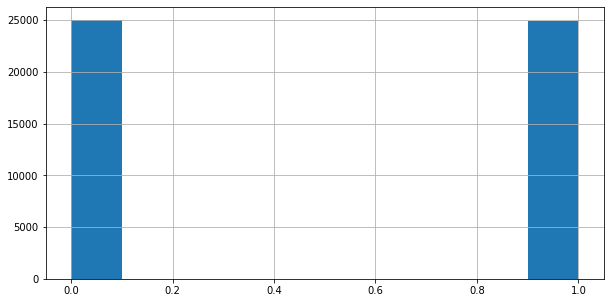

In [ ]:
tYX.Y.hist(figsize=(10,5))

In [ ]:
print(len(tYX)); print(len(vX))

50000
20000


### Features

In this section we analyze our features and their underlying distributions.

At first glance looking at the describe of our features dataframe, we can see that the means for certain columns are rougly equal to their median, suggesting a somewhat symmetric distribution.

In [ ]:
pd.set_option('display.max_rows', 10)
tEmb_eda = pd.DataFrame(tEmb.copy(), index = tYX.index)
# tEmb_eda.describe()

Looking at the specific features in the data that have a mean that is outside of 10% of the median, we can see the distributions below. Looking at the histograms below, even for the features that are in this group, the distributions look fairly normal. It seems the algorithm SBERT generates these features using a fairly normal distribution, with slight deviations in mean which displace the distribution slightly left or right of zero. In general, there does not seem to be any inconsistentcy in the distributions of features.

In [ ]:
# means, medians = tEmb_eda.mean(), tEmb_eda.median()
# out_of_mean_range = list()
# for x in range(len(means)):
#   if (abs(means[x]) < abs(medians[x]) *0.9 or abs(means[x]) > abs(medians[x]) * 1.1) and abs(means[x]) > 0.05:
#     out_of_mean_range.append(x)
# _=tEmb_eda[out_of_mean_range].hist(figsize=(20,20))

### Reducing Dimensionality

In this section we try to reduce the dimensionality of our data. We implement one method using PCA. Another method is using RFE.

#### Principal Component Analysis - UNUSED

Although PCA did help to reduce our feature set, due to the fact we concluded our model was linearly separable. However, keeping all the features improved our models performance overall, so we chose to exclude this from our model.

With 250+ features, the natural first idea was to perform some sort of feature reduction. Looking at the graph generated below using PCA, we were able to find that with about 95 components we are able to caputre 95% of the variance. Thus, we decided to try this in our model.

In [ ]:
# Vectors from SBERT are normalized already'
# # pipeline= Pipeline(steps=[
# #     ("std", StandardScaler())
# #   ])
# tEmb_eda = pd.DataFrame(tEmb.copy(), index = tYX.index)

# # pca = PCA().fit(pipeline.fit_transform(tEmb_eda))
# pca = PCA().fit(tEmb_eda)


# plt.rcParams["figure.figsize"] = (20,6)

# fig, ax = plt.subplots()
# xi = np.arange(1, len(tEmb_eda.columns)+1, step=1)
# y = np.cumsum(pca.explained_variance_ratio_)

# _=plt.ylim(0.0,1.1)
# _=plt.plot(xi, y, marker='o', linestyle='--', color='b')

# _=plt.xlabel('Number of Components')
# _=plt.xticks(np.arange(1, len(tEmb_eda.columns)+1, step=10))
# _=plt.ylabel('Cumulative variance (%)')
# _=plt.title('The number of components needed to explain variance')

# _=plt.axhline(y=0.95, color='r', linestyle='-')
# _=plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

# ax.grid(axis='x')
# plt.show()

#### Recursive Feature Elimination - UNUSED

RFE was able to reduce our feature set to about 195 features. However, we found a more optimal way to increase the effectiveness of our features.

In [ ]:
# rf = RandomForestClassifier(n_estimators = 50, max_depth=8, min_samples_split = 3, min_samples_leaf = 2, random_state=22)
# rfe = RFE(estimator=rf, verbose = 3, step=5)
# tEmb_train, tEmb_test, y_train, y_test = train_test_split(tEmb, tYX.Y, train_size = 0.6, random_state = 22, stratify = tYX.Y)
# rfe.fit(tEmb_train, y_train)

In [ ]:
# features_selected = [3, 4, 6, 8, 9, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 28, 31, 33, 34, 37, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 57, 64, 66, 67, 69, 70, 71, 72, 73, 77, 79, 80, 81, 82, 85, 86, 89, 90, 94, 95, 97, 99, 101, 102, 104, 107, 109, 111, 113, 114, 115, 116, 117, 119, 122, 126, 127, 129, 130, 131, 134, 135, 137, 139, 140, 143, 144, 145, 147, 149, 150, 153, 157, 161, 162, 163, 172, 178, 180, 181, 185, 186, 188, 189, 190, 192, 196, 198, 200, 202, 204, 206, 207, 209, 212, 213, 214, 215, 216, 217, 218, 220, 221, 224, 226, 227, 229, 230, 231, 233, 234, 238, 240, 245, 246, 247, 249, 253, 254, 255, 256, 259, 261, 264, 265, 267, 268, 270, 271, 272, 276, 282, 286, 287, 289, 298, 299, 300, 302, 307, 308, 309, 310, 311, 312, 316, 322, 323, 325, 328, 329, 336, 338, 339, 340, 342, 343, 350, 351, 354, 355, 357, 358, 359, 360, 361, 364, 365, 366, 370, 371, 372, 373, 377, 379, 380, 382, 383]

In [ ]:
# tEmb_rfe = tEmb_eda.iloc[:,features_selected]

PCA With RFE

In [ ]:
# pipeline= Pipeline(steps=[
#     ("std", StandardScaler())
#   ])

# pca = PCA().fit(pipeline.fit_transform(tEmb_rfe))

# plt.rcParams["figure.figsize"] = (20,6)

# fig, ax = plt.subplots()
# xi = np.arange(1, len(tEmb_rfe.columns)+1, step=1)
# y = np.cumsum(pca.explained_variance_ratio_)

# _=plt.ylim(0.0,1.1)
# _=plt.plot(xi, y, marker='o', linestyle='--', color='b')

# _=plt.xlabel('Number of Components')
# _=plt.xticks(np.arange(1, len(tEmb_rfe.columns)+1, step=10))
# _=plt.ylabel('Cumulative variance (%)')
# _=plt.title('The number of components needed to explain variance')

# _=plt.axhline(y=0.95, color='r', linestyle='-')
# _=plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

# ax.grid(axis='x')
# plt.show()

### Preprocessing Pipeline

Using the number of components we computed from the analysis above, we are able to now create a preprocessing pipeline that will return a our transformed data. We remove the standard scaler because SBERT returns normalized vectors for us already.

In [ ]:
def preprocess_pipe(X=[], n_comp=[], use_pca=True):
    pipeline = Pipeline(steps=[('scaler', StandardScaler())])

    for i in range(len(X)):
      X[i] = pipeline.fit_transform(X[i])
      if use_pca:
        X[i] = PCA(n_components=n_comp[i]).fit_transform(X[i])
    return np.concatenate(X, axis=1)

### Feature Engineering

In this section we implement a function that will build new features within our data. We take the counts and DNA segment length as two featurse. Using the counts we compute the pairwise nucleotide content within our data. After performing EDA, we found gc and ta content were significant to helping our model.

In [ ]:
def build_features(df_tYX):
    df_tYX['cntC'] = [s.count('C') for s in df_tYX.DNA]
    df_tYX['cntT'] = [s.count('T') for s in df_tYX.DNA]
    df_tYX['cntG'] = [s.count('G') for s in df_tYX.DNA]
    df_tYX['cntA'] = [s.count('A') for s in df_tYX.DNA]
    ctContent = ((df_tYX.cntC+df_tYX.cntT)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['ctContent'] = ctContent
    gcContent = ((df_tYX.cntC+df_tYX.cntG)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['gcContent'] = gcContent
    caContent = ((df_tYX.cntC+df_tYX.cntA)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['caContent'] = caContent
    tgContent = ((df_tYX.cntT+df_tYX.cntG)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['tgContent'] = tgContent
    taContent = ((df_tYX.cntT+df_tYX.cntA)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['taContent'] = taContent
    gaContent = ((df_tYX.cntG+df_tYX.cntA)+1)/((df_tYX.cntC+df_tYX.cntG+df_tYX.cntA+df_tYX.cntT)+1)
    df_tYX['gaContent'] = gaContent
    df_tYX['dnaSegLen'] = [len(i) for i in df_tYX.DNA]
    return df_tYX

new_features = ['cntC', 'cntT', 'cntG', 'cntA', 'gcContent', 'ctContent', 
                'caContent', 'tgContent', 'taContent', 'gaContent', 'dnaSegLen']


## **Task 2. Modeling Approach**
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful. 

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements? 
1. What else have you tried that worked or didn't? 

**Student's answer:**

1. 
 
We have implemented two different models (DNN and SVC). Based on our experiment, SVC gave better validation score even though DNN sometimes give better training score. So, we have decided that DNN has more risk on overfitting than the linear SVC. So we have decided to maximize our score based on SVC rather than DNN because SVC gave better score from the Kaggle leader board. We have concluded that linear SVC would be better model than DNN for generalization for this data set.

2. 
* <b> Scoring metric:</b>
We used the classification accuracy as our scoring metric because that is the requirement for this competition. We have calculated the accuracy by comparing the class label between the actual one and the predcited one from the traning set.  

* <b> Running time:</b>
There is a running time limit for this competition (300 sec) . We measured the execution time to check if the code can be run within the time limit. To expedite our calcuation, we used GPU and checked the running time by multiple trials to see if the entire code can run within the time limit.

* <b> Overfitting:</b>
To evaludate the overfitting, we compared the training score and validation score. Also, we checked the score from the Kaggle leader board to see if our model overfits. 

3. Details about what we have tried are specified with the markdown on top of its own code cell. 


#### DNN Classifier

Our first attempt to build the model was with a DNN and DNN bagging classifier. The code implementation can be seen below. We utilized custom lr decays and bagging; however, we struggled to find a model that generalized well as we ran into the constant problem of overfitting.

In [ ]:
class MonteCarloDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


def build_model(n_hidden=5, n_neurons=300, learning_rate=0.5, input_shape=[250], 
                metrics=['accuracy'], 
                dropout_rate = 0.2, 
                kernel_reg = 0.01,
                opt_type='SGD'):
    Init = tf.keras.initializers.HeUniform(seed=22) 
    InitOutput = tf.keras.initializers.GlorotNormal(seed=22) 
    kernel_reg = keras.regularizers.L2(kernel_reg)
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape, name='input'))
    # model.add(keras.layers.Dense(n_neurons, input_shape=input_shape, activation="elu", kernel_initializer=Init, kernel_regularizer=kernel_reg, name=f"input_layer"))
    model.add(keras.layers.BatchNormalization())
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="elu", kernel_initializer=Init, kernel_regularizer=kernel_reg, name=f"hidden_{layer+1}"))
        # model.add(tf.keras.layers.SimpleRNN(n_neurons, activation="elu", kernel_initializer=Init, name=f"hidden_{layer+1}"))
        # model.add(keras.layers.Dropout(rate=dropout_rate, seed = 22))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=InitOutput, name="output"))
    if opt_type == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif opt_type == 'Adamax':
        optimizer = keras.optimizers.Adamax(learning_rate=learning_rate)
    elif opt_type == 'Adagrad':
      optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif opt_type == 'Nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    elif opt_type == 'Ftrl':
        optimizer = keras.optimizers.Ftrl(learning_rate=learning_rate)
    else:
        raise exception("Bad Optimizer, only SGD, Adamax, Nadam and Ftrl")
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    # model.summary()
    return model


def lr_scheduler_decay(epoch, lr):
    # if epoch % 5 == 0 and epoch != 0:
    #   decay = 0.5
    # else:
    #   decay = 1
    decay = 0.97
    return lr * decay

def lr_scheduler_decay_batch(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        decay = 0.5
    else:
        decay = 1
    # decay = 0.97
    return lr * decay

class BaggingKerasClassifier:
    members = []

    def __init__(self, estimator, n_estimators=10):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.members = list()

    def fit(self, X, y):
        member = deepcopy(self.estimator)
        for i in range(self.n_estimators):
            X_rs, y_rs = resample(X, y, random_state = 22, stratify = y)
            X_train, X_test, y_train, y_test = train_test_split(X_rs, y_rs, test_size=0.2, shuffle = True, random_state=22, stratify = y_rs)
            X_test = member['scaler'].fit_transform(X_test)
            _=member.set_params(model__validation_data=(X_test, y_test))
            _=member.fit(X_train,y_train)
            self.members.append(member)
        return self.members

    def predict(self, X):
        # make predictions
        yhats = [model.predict(X) for model in self.members]
        yhats = np.array(yhats)
        # sum across ensemble members and divide by number of estimators
        summed = np.sum(yhats, axis=0)/self.n_estimators

        # return the rounded result
        result = (summed>0.5)*1
        return result




In [ ]:
# keras.backend.clear_session()
# with tf.device('/device:GPU:0'):
#     tY = tYX.Y.copy()
#     tX = preprocess_pipe([tEmb], use_pca=False)

    
#     tf.random.set_seed(22)   # always seed your experiments
#     fm_test = build_model(n_hidden=5, n_neurons=500, learning_rate=0.05, input_shape=[tX.shape[1]], 
#                 metrics=['accuracy'], 
#                 # dropout_rate = 0.2,
#                 kernel_reg = 0.1,
#                 opt_type='SGD')
    
#     lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_decay)
#     lr_decay_callback_batch = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_decay_batch)

# #     fm_test.summary()
    
#     skf = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=22)
#     tX_reset = tX
#     tY_reset = tY.reset_index(drop=True)
#     set_num = 1
#     tf.random.set_seed(22)   # always seed your experiments
#     for train_index, test_index in skf.split(tX_reset, tY_reset):
#         X_train, X_test = tX_reset[train_index],tX_reset[test_index]
#         y_train, y_test = tY_reset.loc[train_index], tY_reset.loc[test_index]
#         # keras.backend.set_value(fm_test.optimizer.learning_rate, 0.05)
#         # hist2 = fm_test.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=1200)
#         keras.backend.set_value(fm_test.optimizer.learning_rate, 0.05)
#         hist1 = fm_test.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=1200, callbacks=[lr_decay_callback])
#         keras.backend.set_value(fm_test.optimizer.learning_rate, 0.0005)
#         hist2 = fm_test.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=1200)
#         set_num += 1

In [ ]:
# for x in range(0,25):
#   threshold = 0.4 + x * 0.01
#   print(threshold)
#   predicted_tX = ((pd.DataFrame(fm_test.predict(tX), columns=['y'])>0.5)*1)
#   print(classification_report(predicted_tX.astype(int), tYX.Y, digits=6))
#   print("----------------------------------------------------------")
#   test_acc = accuracy_score(predicted_tX.astype(int), tYX.Y)
#   print("Test Score: ", test_acc)
#   print("----------------------------------------------------------")

In [ ]:
# # vEmb_proccessed = preprocess_pipe(vEmb, n_comp = 95)
# vEmb_proccessed = preprocess_pipe([vEmb], use_pca=False)
# pY = ((pd.DataFrame(fm_test.predict(vEmb_proccessed), index=vX.index, columns=['y'])>0.5)*1)   # predicted targets
# ToCSV(pY, 'DNN_Regularized_SBERT_3Words')

#### Bagging Neural Network Classifier

In [ ]:
# keras.backend.clear_session()
# with tf.device('/device:GPU:0'):
#   tX_ohe = tEmb.copy()
#   tY_ohe = tYX.Y.copy()

#   tf.random.set_seed(22)   # always seed your experiments
#   col = len(tX_ohe[0])
#   ct = ColumnTransformer([
#             ('scaler', StandardScaler(), list(range(0, col)))
#         ], remainder='passthrough')


#   keras.backend.clear_session()
#   lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_decay)
#   lr_decay_callback_batch = tf.keras.callbacks.LearningRateScheduler(lr_scheduler_decay_batch)
#   keras_classifier = keras.wrappers.scikit_learn.KerasClassifier(build_model,
#                                                                  n_hidden=6, 
#                                                                  n_neurons=300, 
#                                                                  learning_rate=0.1, 
#                                                                  input_shape=[tX_ohe.shape[1]], 
#                                                                  epochs=60, 
#                                                                  batch_size=800, 
#                                                                  callbacks = [lr_decay_callback], 
#                                                                  validation_data = None,
#                                                                  validation_split = 0.2,
#                                                                  verbose=2)
  
#   ## Start with a prefit model that is fit on the original data before bagging
#   tX_ohe_test = ct.fit_transform(tX_ohe)
#   keras_classifier.fit(tX_ohe_test, tY_ohe)

#   pipeline = Pipeline([('scaler', ct), ('model', keras_classifier)])

#   _=pipeline.set_params(model__validation_split = None, 
#                         model__epochs = 60, 
#                         model__learning_rate = 0.005,
#                         model__callbacks = [lr_decay_callback_batch],
#                         model__verbose = 2
#                         )

#   bg_classifier = BaggingKerasClassifier(estimator=pipeline, n_estimators=5)

#   models = bg_classifier.fit(tX_ohe, tY_ohe)

In [ ]:
# predicted_tX = ((pd.DataFrame(bg_classifier.predict(tX_ohe), columns=['y'])>0.5)*1)
# print(classification_report(predicted_tX.astype(int), tYX.Y, digits=6))
# print("----------------------------------------------------------")
# test_acc = accuracy_score(predicted_tX.astype(int), tYX.Y)
# print("Test Score: ", test_acc)
# print("----------------------------------------------------------")

In [ ]:
# pY_bg = ((pd.DataFrame(bg_classifier.predict(vEmb), index=vX.index, columns=['y'])>0.5)*1)   # predicted targets
# ToCSV(pY_bg, 'DeepNeuralNetwork_BaggingClassifier_ADAM')
# pY_bg.hist()

### Linear SVC + Bagging

We attempted to try SVC with bagging to help generalize our model. However, performance did not improve.

In [ ]:
# tX = tEmb_rfe.copy()
# tX = preprocess_pipe(tX, n_comp=65)
# pf = PolynomialFeatures(degree=2)
# tX = pf.fit_transform(tX)

# m_baseline = LinearSVC(random_state=0, max_iter=10000, loss = 'squared_hinge', C=1, dual=True, penalty = 'l2', fit_intercept = False, intercept_scaling=1)  # SVC is ok to use. See updated Rules.
# m_baseline.fit(tX, tYX.Y)
# # %time m_baseling_bg = BaggingClassifier(m_baseline, n_estimators = 5, max_features=1.0, random_state=22).fit(tEmb, tYX.Y)
# m_baseline.score(tX, tYX.Y)   # in-sample accuracy

In [ ]:
# pY_baseline_bag = (pd.DataFrame(m_baseline.predict(vEmb), index=vX.index, columns=['y'])>0.5)*1  # predicted targets
# ToCSV((pY_baseline>0.5)*1, 'Baseline_updated')

In [ ]:
# predicted_tX = ((pd.DataFrame(m_baseling_bg.predict(tX_ohe), columns=['y'])>0.5)*1)
# print(classification_report(predicted_tX.astype(int), tYX.Y, digits=6))
# print("----------------------------------------------------------")
# test_acc = accuracy_score(predicted_tX.astype(int), tYX.Y)
# print("Test Score: ", test_acc)
# print("----------------------------------------------------------")

### Linear SVC

#### Polynomial Features - UNUSED

Using polynomial features actually decreased our score due to the trade off between lowering the number of components vs adding polynomial interactions.

In [ ]:
# with tf.device('/device:GPU:0'):
#   tEmb_pca = preprocess_pipe([tEmb], n_comp=[80])
#   pf = PolynomialFeatures(degree=2)
#   tEmb_pca = pf.fit_transform(tEmb_pca)

#   %time m_baseline = LinearSVC(random_state=0, max_iter=3000, C=0.5).fit(tEmb_pca, tYX.Y)  # SVC is ok to use. See updated Rules.
#   m_baseline.score(tEmb_pca, tYX.Y)   # in-sample accuracy

#   # vEmb_pca = preprocess_pipe([vEmb], n_comp=[50])
#   # pf = PolynomialFeatures(degree=2)
#   # vEmb_pca = pf.fit_transform(vEmb_pca)
#   # pY_baseline_poly = pd.DataFrame(m_baseline.predict(vEmb_pca), index=vX.index, columns=['y'])   # predicted targets
#   # ToCSV((pY_baseline>0.5)*1, 'LinearSVC_4partSBERT_all_MiniLM_L6')


#### K-means Clustering

Using k-means clustering to add the label as a feature

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def apply_k_means(df,k):
  scaler=StandardScaler()
  df_scaled=pd.DataFrame(scaler.fit_transform(df))
  minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
  minibatch_kmeans.fit(df_scaled)
  clusters = pd.DataFrame(minibatch_kmeans.predict(df_scaled), columns=["k_means_cluster"])
  clusters_dummy=pd.get_dummies(clusters["k_means_cluster"],prefix="cluster")
  result=pd.concat([df_scaled,clusters_dummy],axis=1)
  return result
  

#### Preprocessing

Our data preprocessing pipeline including the KMeans implementation and cosine similarity implementation

#### Cosine Similarity + KMeans

One more feature that we decided to add to our model was a cosine similarity score for 0 or 1 classes. To implement this cosine similarity, first we make use of the split data that we initially made embeddings on. In our first model creation step, we split our data by 0.5. We take a subsample of the remaining data (10000 observations), denominated by their underlying class (0 or 1). Finally, we use the util.cos similarity score and take the mean of the scores of each training and test observation relative to subsample embedding we created. Each observation in the test and train sample gets its own average cos similarity score added as a feature to the model for both classes 0 and 1:



*   0Score = mean of cos_sim(50000 test obs, 10000 holdout class 0 obs) per row and repeated for vEmb
*   1Score = mean of cos_sim(50000 test obs, 10000 holdout class 1 obs) per row and repeated for vEmb



In [ ]:
from sentence_transformers import util

zero_scores = util.cos_sim(tEmb,embeddings_train_feature0)
one_scores = util.cos_sim(tEmb,embeddings_train_feature1)
zero_scores_test = util.cos_sim(vEmb,embeddings_train_feature0)
one_scores_test = util.cos_sim(vEmb,embeddings_train_feature1)

In [ ]:
tYX = build_features(tYX)
tEmb_train = pd.DataFrame(tEmb, index=tYX.index, columns=pd.Series(range(0,384), dtype="string").tolist())
tEmb_train['0score'] = 0
tEmb_train['1score'] = 1

for row in range(len(tEmb_train)):
    tEmb_train.iloc[row,384] = zero_scores[row].mean().item()
    tEmb_train.iloc[row,385] = one_scores[row].mean().item()

tEmb_train = pd.concat([tEmb_train, tYX.loc[:,new_features]], axis=1)
tEmb_train = apply_k_means(tEmb_train,6)
tEmb_train = preprocess_pipe([tEmb_train], use_pca=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
vX = build_features(vX)
vEmb_test = pd.DataFrame(vEmb, index=vX.index, columns=pd.Series(range(0,384), dtype="string").tolist())
vEmb_test['0score'] = 0
vEmb_test['1score'] = 1
for row in range(len(vEmb_test)):
    vEmb_test.iloc[row,384] = zero_scores_test[row].mean().item()
    vEmb_test.iloc[row,385] = one_scores_test[row].mean().item()

vEmb_test = pd.concat([vEmb_test, vX.loc[:,new_features]], axis=1)
vEmb_test = apply_k_means(vEmb_test,6)
vEmb_test = preprocess_pipe([vEmb_test], use_pca=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


#### UNUSED OLD SECTION FOR PREPROCESSING

In [ ]:
# tYX = build_features(tYX)
# tEmb_train = pd.DataFrame(tEmb, index=tYX.index, columns=pd.Series(range(0,384), dtype="string").tolist())
# tEmb_train = pd.concat([tEmb_train, tYX.loc[:,new_features]], axis=1)
# tEmb_train = apply_k_means(tEmb_train,6)
# tEmb_train = preprocess_pipe([tEmb_train], use_pca=False)

In [ ]:
# vX = build_features(vX)
# vEmb_test = pd.DataFrame(vEmb, index=vX.index, columns=pd.Series(range(0,384), dtype="string").tolist())
# vEmb_test = pd.concat([vEmb_test, vX.loc[:,new_features]], axis=1)
# vEmb_test = apply_k_means(vEmb_test,6)
# vEmb_test = preprocess_pipe([vEmb_test], use_pca=False)

#### Final Model

Our final model utilizes LinearSVC without bagging as we found bagging did not help generalize our model. We split our data by 0.8 to test our model on a validation set. We tuned our C regularization to the best, most appropriate level to achieve the highest validation score.

In [ ]:
with tf.device('/device:GPU:0'):
  

  X_train, X_test, y_train, y_test = train_test_split(tEmb_train, tYX.Y, train_size=0.8, random_state=22, shuffle = True, stratify = tYX.Y)

  m_svc = LinearSVC(random_state=22, max_iter=10000, C=0.007, dual=False, fit_intercept=True).fit(X_train, y_train)  # SVC is ok to use. See updated Rules.
  print("Train Accuracy: ", m_svc.score(X_train, y_train))   # in-sample accuracy
  print("Validation Accuracy: ", m_svc.score(X_test, y_test))
  print("Accuracy: ", m_svc.score(tEmb_train,tYX.Y))

Train Accuracy:  0.980975
Validation Accuracy:  0.9806
Accuracy:  0.9809


In [ ]:
pY_linSVC = pd.DataFrame(m_svc.predict(vEmb_test), index=vX.index, columns=['y'])   # predicted targets
ToCSV((pY_linSVC>0.5)*1, 'LinearSVC_with_kmeans_and_0score1score')

In [ ]:
pY_linSVC.value_counts()

y
0    10012
1     9988
dtype: int64

### Baseline Model

In [ ]:
# tf.random.set_seed(0)   # always seed your experiments
# Init = keras.initializers.RandomNormal(seed=0)
# import numpy as np

# m = keras.models.Sequential([
#     Flatten(input_shape=[tEmb.shape[1]]),
#     Dense(100, activation="relu", kernel_initializer=Init),
#     Dense(1, activation='sigmoid', kernel_initializer=Init)])
# m.summary()
# m.compile(loss="binary_crossentropy", optimizer="sgd", metrics=['binary_accuracy'])
# hist = m.fit(tEmb, np.array(tYX.Y), batch_size=64, epochs=10, validation_split=0.3)

# **References:**

1. https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/
2. Géron, A. (2019). Hands-on machine learning with scikit-learn, keras, and tensorflow: Concepts, tools, and techniques to build intelligent systems (2nd edition). O'Reilly Media.
3. https://medium.com/mlearning-ai/apply-machine-learning-algorithms-for-genomics-data-classification-132972933723#f04f
4. https://sourmash.readthedocs.io/en/latest/kmers-and-minhash.html
5. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 246 sec


# 💡**Starter Ideas**

1. Learn about DNA [&#127910;](https://www.youtube.com/results?search_query=nucleotides+genes+amino+acids+)
1. Try a larger training sample. 
1. Try longer training DNA strings, but SBERT may have a cap on string length, so you might split DNA into several strings and then concatenate or average resulting vectors
1. Try other pretrained SBERT models. Note that DNA sequence uses ACGT letters, but many other models were trained on multilingual text. So, you might prefer those that were trained on mostly ASCII.
1. SBERT is trained on word tokens (typically, separated by spaces), but DNA sequence has no spaces. Try placing spaces after every character or some semantically meaningful subsequences (this might require more domain knowledge).
1. Try Google's [USE](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3) embedding models
1. Try Facebook's [LASER](https://github.com/facebookresearch/LASER) and [others](https://tfhub.dev/s?module-type=text-language-model). 
1. Try [Enformer](https://tfhub.dev/deepmind/enformer/1) for gene expressions. See [DeepMind paper](https://deepmind.com/blog/article/enformer).
1. Try building your own embeddings on the given sequences. SBERT and other packages make it easy (just a few lines), but it may take too much time.
1. Assess distribution of character patterns (single, doubles, triplets, ...). For example, an ACGT string generates AC, CG, GT doubles and ACG and CGT triplets. Does one class have more subsequences of some type? This might be a feature in your model. 
1. Try features built as counts of subsequences (singles, doubles, triplets, ...). Consider EDA first.
1. Concatenate or otherwise combine multiple embeddings derived from each gene string
1. Learn from [*The genetic code*](https://www.khanacademy.org/science/ap-biology/gene-expression-and-regulation/translation/a/the-genetic-code-discovery-and-properties), Khan Academy.
1. Learn from [*Apply Machine Learning Algorithms for Genomics Data Classification*](https://medium.com/mlearning-ai/apply-machine-learning-algorithms-for-genomics-data-classification-132972933723)
1. Learn from [*Efficient counting of k-mers in DNA sequences using a bloom filter*](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-333) Páll Melsted et al. 2011
1. Try [Byte Pair Encoding](https://www.derczynski.com/papers/archive/BPE_Gage.pdf) and [SentencePiece](https://arxiv.org/pdf/1808.06226.pdf) to auto identification of "important" [k-mers](https://en.wikipedia.org/wiki/K-mer) (substrings)